# **Random Forest Classifier to Predict Molecular Toxicity**

The following notebook details the workflow to create a random forest classifier ML algorithm to predict the toxicity of molecules from their molecular structures. This is adapted from the “Toxicology in the 21st Century” (Tox21) initiative; a public database measuring toxicity of compounds, which has been used in the 2014 Tox21 Data Challenge (https://tripod.nih.gov/tox21/challenge/data.jsp). This dataset contains qualitative toxicity measurements for 8k compounds on 12 different targets, including nuclear receptors and stress response pathways.

RF algorithms require inputs of set size. DeepChem's Extended Connectivity Fingerprint (ECFP) featurizer can featurize the molecular structures in this case. Random Forest classifiers work on the principle of creating an ensemble of decision trees from bootstrapped datasets (datasets created from taking samples from the original). The prediction returned by the model is determined by majority vote (i.e., the modal output of all combined outputs from all decision trees). This is a powerful technique to overcome overfitting that simple decision trees face to produce a relatively accurate and generalised model. 

* The biggest downside of these types of approaches is the fact that predictions of the toxicity of unseen molecules will be relatively slow due to the computational demand of running the molecule through hundreds of distinct decision trees.

### Import libraries

In [1050]:
import deepchem as dc 
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Load dataset

Deepchem uses diskdatasets to store the data. Here, the extended connectivity fingerprint (ECFP) featurizer is used to convert drawn chemical structures of molecules into an 1024-dimensional array (1024 features to describe the structure of each molecule in the dataset). These features can be used to create a RF classifier in Sklearn after some data pre-processing.

Note, the researchers responsible for generating the dataset for the initiative have included weights for each of the results of each assay to rank their relative significance. Compounds which are exotic and do not appear often in the dataset will have higher weightings as these results are more significant. Additionally, a paper published by the MoleculeNet group (https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) on this problem suggests a random splitter is the most appropriate way to split the data into training and testing sets.

In [1051]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP', splitter='random')
train_dataset, valid_dataset, test_dataset = datasets
print(train_dataset)

<DiskDataset X.shape: (6264, 1024), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>


### Creating the training and testing datasets

This project is only concerned with predicting toxicity against the nuclear receptor targets (y1-y7), hence why the stress receptor target results (y8-y12) are dropped.

The dataframes below show the process of manipulating the datasets into training and testing sets. The training dataset contains 6264 molecules alongside their associated assay results (0 for non-toxic, 1 for toxic) for the seven nuclear receptors (y1-y7) as well as the 1024 features used to describe each molecule. Each task has an associated weight (w1-w7) which has been included by the researchers who collected the data and can be used to weight the significance of each result to train a more generalised and accurate model. Finally, the molecule's associated SMILES string is listed under 'ids' to display the molecular structures using the rdkit library.

IMPORTANT: 
* The dataset is imbalanced, so oversampling is used to randomly copy toxic molecule entries such that the proportion of toxic and non-toxic molecules in the train dataset is equal. 
* We must remove the weights from the training and testing datasets since the model would otherwise learn that toxic molecules have higher weights and be able to predict toxicity of the test dataset from the weights alone (this is obviously not what we want - we need to predict toxicity from the molecular structure features, not the man-made weights).

In [1052]:
train_df = train_dataset.to_dataframe()
test_df = test_dataset.to_dataframe()
valid_df = valid_dataset.to_dataframe()

print(train_df)

       X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  ...         w4  \
0     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   1.052894   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   1.052894   
2     0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0.0   
4     0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  ...        0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...        ...   
6259  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  19.905579   
6260  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   1.052894   
6261  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   1.052894   
6262  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   1.052894   
6263  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   1.052894   

            w5        w6        w7        w8        w9        w10       w11  \
0          0.0  1.052293  1.0292

In [1053]:
ECFP = train_df.iloc[:, :1024]

weights_ids = train_df.iloc[:, 1036:]

X_train = train_df.drop(['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12','ids'], axis = 1)
                        
X_test = test_df.drop(['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'ids'], axis = 1)

y_train = train_df.iloc[:, 1024:1031]

y_test = test_df.iloc[:, 1024:1031]

train_ids = train_df[['ids']]

test_ids = test_df[['ids']]

In [1054]:
X_train

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1015,X1016,X1017,X1018,X1019,X1020,X1021,X1022,X1023,X1024
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6260,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1055]:
y_train

,y1,y2,y3,y4,y5,y6,y7
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
6259,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6260,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6261,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6262,0.0,0.0,0.0,0.0,0.0,0.0,0.0



To simplify our problem, we can say that if a molecule has an interaction with *any* of the seven nuclear receptors, we consider that molecule a toxicity risk and flag it as toxic. This means we can simply combine the seven assay results into one. If any of the assay results flag toxic (1) then the combined toxicity column must also be 1:

In [1056]:
y_train['Toxsum'] = y_train.sum(axis=1)

y_train['Tox'] = np.where(y_train['Toxsum'] > 0, 1, 0)

y_test['Toxsum'] = y_test.sum(axis=1)

y_test['Tox'] = np.where(y_test['Toxsum'] > 0, 1, 0)

y_test

,y1,y2,y3,y4,y5,y6,y7,Toxsum,Tox
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [1057]:
y_train = y_train.drop(['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'Toxsum'], axis=1)
y_test = y_test.drop(['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'Toxsum'], axis=1)

In [1058]:
y_train

,Tox
0,1
1,0
2,0
3,1
4,0
...,...
6259,1
6260,0
6261,0
6262,0


In [1059]:
y_test

,Tox
0,0
1,0
2,0
3,1
4,0
...,...
779,0
780,0
781,0
782,0


In [1060]:
train_df = pd.concat([X_train, y_train], axis = 1)

test_df = pd.concat([X_test, y_test], axis = 1)

In [1061]:
train_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1016,X1017,X1018,X1019,X1020,X1021,X1022,X1023,X1024,Tox
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6260,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
6261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [1062]:
test_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1016,X1017,X1018,X1019,X1020,X1021,X1022,X1023,X1024,Tox
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
780,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
781,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
782,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Oversampling to balance the dataset

In [1063]:
from sklearn.utils import resample

percent_toxic = 100*sum(train_df['Tox'])/len(train_df)
percent_non_toxic = 100 - percent_toxic

df_majority = train_df[train_df.Tox==0]
df_minority = train_df[train_df.Tox==1]

df_minority_oversampled = resample(df_minority, 
                                 replace=True, 
                                 n_samples= int(percent_non_toxic*len(train_df)/100))

df_oversampled = pd.concat([df_majority, df_minority_oversampled])

df_oversampled

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1016,X1017,X1018,X1019,X1020,X1021,X1022,X1023,X1024,Tox
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
675,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3455,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


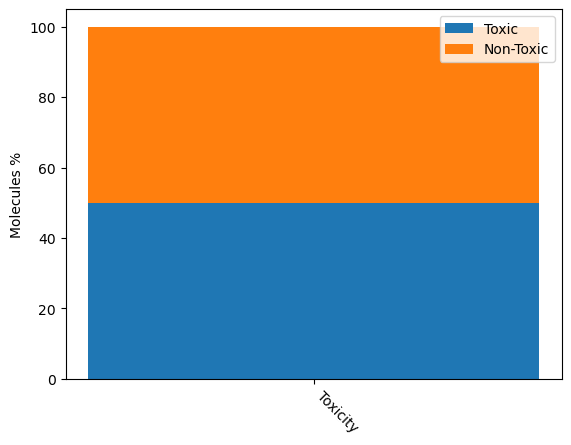

In [1064]:
from matplotlib import pyplot as plt

percent_toxic = 100*sum(df_oversampled['Tox'])/len(df_oversampled)
percent_non_toxic = 100-percent_toxic

ax=plt.bar('Toxicity',percent_toxic, label='Toxic')
plt.bar('Toxicity',percent_non_toxic, bottom= percent_toxic, label='Non-Toxic')
plt.xticks(rotation=-45, ha='left')
plt.ylabel("Molecules %")
plt.legend()

In [1065]:
X_train = df_oversampled.drop(['Tox'], axis = 1)

y_train = df_oversampled[['Tox']]

In [1066]:
X_train

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1015,X1016,X1017,X1018,X1019,X1020,X1021,X1022,X1023,X1024
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
675,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3455,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1067]:
y_train

,Tox
1,0
2,0
4,0
5,0
6,0
...,...
4397,1
675,1
3881,1
3455,1


### Model creation

In [1068]:
clf = RandomForestClassifier(criterion='gini',   # gini criteron measures the probability of misclassification for each split - values close to zero are ideal.
                             max_depth = 10,     # maximum depth of each decision tree
                             min_samples_split = 20,  # minimum number of samples required to split an internal node
                             random_state = 5)

In [1069]:
clf.fit(X_train, y_train)

c:\Users\cu19339\AppData\Local\anaconda3\envs\ml-for-chemists-tf2\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(max_depth=10, min_samples_split=20, random_state=5)

In [1070]:
clf.feature_importances_

# this doesn't really mean much in this case since the features are incomprehensible to us - each feature is either a zero or one and does not directly relate to a comprehensable property of the molecular structure

array([0.00025389, 0.0017359 , 0.00044554, ..., 0.00024238, 0.00021122,
       0.00040453])

In [1071]:
y_pred = clf.predict(X_test)

In [1072]:
y_pred

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,

### Evaluating the model

In [1073]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[414, 168],
       [ 75, 127]], dtype=int64)

The confusion matrix suggests the model is slightly more accurate than random guessing with 243 misclassifications out of the total 784 tested molecular structures (~69% accuracy). It is worth noting that in this scenario, it is highly important to mimimize false negative results (i.e., model predicting toxic molecules to be non-toxic), hence the f2 metric is a sensible choice for model evaluation. It is encouraging that of the misclassified molecules, there are roughly half as many false negatives as false positives.

In [1074]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6900510204081632

In [1075]:
# f2 score
from sklearn.metrics import fbeta_score
fbeta_score(y_test, y_pred, beta=2)

0.5757026291931097

An f2 score of ~58% is ok, but does not rival the state-of-the-art models.

In [1076]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X_train, y_train, cv=10)

c:\Users\cu19339\AppData\Local\anaconda3\envs\ml-for-chemists-tf2\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


c:\Users\cu19339\AppData\Local\anaconda3\envs\ml-for-chemists-tf2\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\cu19339\AppData\Local\anaconda3\envs\ml-for-chemists-tf2\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\cu19339\AppData\Local\anaconda3\envs\ml-for-chemists-tf2\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\User

array([0.75263158, 0.70842105, 0.76      , 0.72315789, 0.75578947,
       0.73894737, 0.73368421, 0.74842105, 0.72918862, 0.77239199])

In [1077]:
from sklearn.metrics import classification_report
classification_report(y_pred, y_test)

'              precision    recall  f1-score   support\n\n           0       0.71      0.85      0.77       489\n           1       0.63      0.43      0.51       295\n\n    accuracy                           0.69       784\n   macro avg       0.67      0.64      0.64       784\nweighted avg       0.68      0.69      0.67       784\n'

### Visualising the molecules

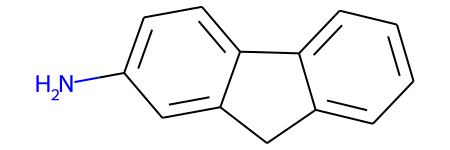

In [1078]:
# Outputs the structures that the classifier was trained on
train_SMILES_strings = train_ids['ids']
molecule = 7
toxic = y_train.iloc[molecule]
smiles = train_SMILES_strings[molecule]
structure = Chem.MolFromSmiles(smiles)

structure

In [1079]:
# Outputs whether each molecule is truly toxic
toxic

Tox    0
Name: 11, dtype: int32

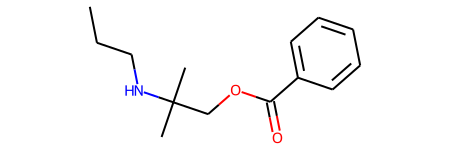

In [1080]:
# Outputs the structures that the classifier was tested on
test_SMILES_strings = test_ids['ids']
molecule = 304
toxic = y_test.iloc[molecule]
smiles = test_SMILES_strings[molecule]
structure = Chem.MolFromSmiles(smiles)

structure

In [1081]:
# Outputs whether each of the molecules in the test set is truly toxic
toxic

Tox    1
Name: 304, dtype: int32

In [1082]:
# Outputs the prediction made by the classifier
y_pred[molecule]

1

In [1083]:
# Lists all incorrect predictions made by the model
incorrect = []
for i in range(0, 783):
  if int(y_pred[i]) != int(y_test.iloc[i].values):
    incorrect.append(int(i))
print(incorrect)

[0, 4, 7, 8, 9, 11, 17, 18, 19, 20, 22, 23, 28, 31, 35, 39, 40, 43, 44, 45, 55, 56, 57, 61, 62, 63, 66, 67, 69, 71, 75, 77, 85, 87, 90, 92, 93, 100, 101, 104, 106, 108, 110, 114, 119, 121, 127, 130, 133, 139, 142, 143, 148, 149, 153, 155, 159, 161, 162, 165, 177, 178, 182, 186, 188, 190, 191, 194, 197, 205, 215, 217, 220, 221, 225, 229, 231, 239, 242, 243, 247, 255, 258, 260, 270, 271, 273, 277, 278, 280, 290, 291, 299, 303, 305, 308, 320, 323, 330, 332, 336, 340, 343, 345, 348, 353, 361, 369, 370, 371, 372, 373, 375, 379, 380, 382, 384, 385, 388, 391, 396, 400, 401, 404, 406, 418, 419, 421, 422, 423, 424, 430, 432, 433, 436, 437, 444, 447, 450, 451, 453, 456, 458, 461, 465, 469, 475, 477, 478, 479, 481, 485, 489, 493, 494, 496, 498, 499, 501, 507, 513, 516, 517, 522, 523, 524, 525, 530, 533, 536, 539, 540, 542, 543, 546, 547, 548, 550, 551, 556, 562, 567, 572, 573, 577, 582, 586, 592, 598, 601, 602, 605, 606, 608, 609, 613, 616, 617, 618, 621, 622, 623, 633, 638, 639, 642, 643, 645, 6

c:\Users\cu19339\AppData\Local\anaconda3\envs\ml-for-chemists-tf2\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:254: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


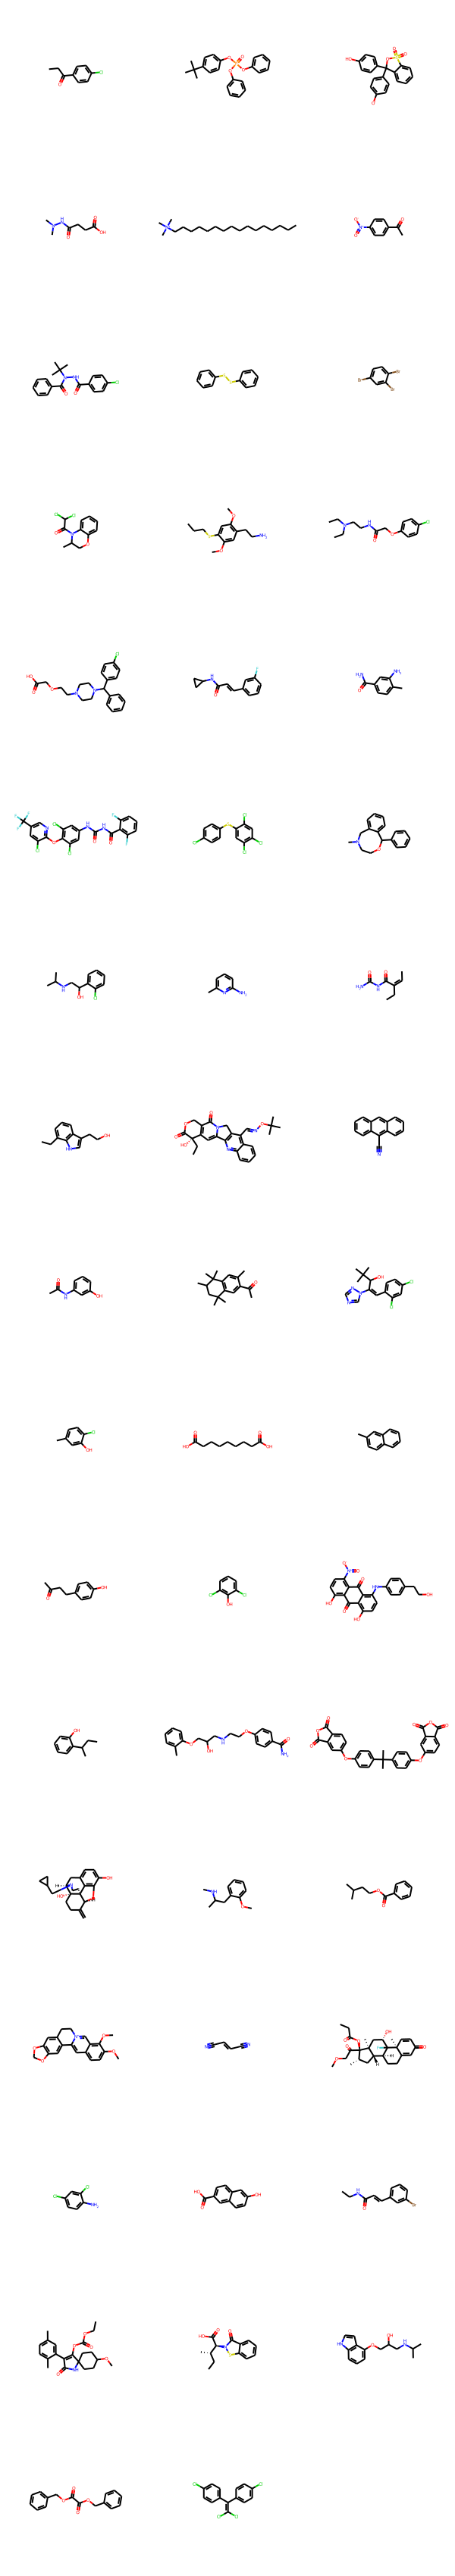

In [1084]:
SMILES_strings = test_ids.iloc[incorrect]['ids']
ms = [Chem.MolFromSmiles(x) for x in SMILES_strings] 
Draw.MolsToGridImage(ms)

### Testing the model on known toxins outside of the Tox21 Dataset

To further validate the model and check for overfitting, a small number of known potent toxins (including Sarin, VX, neostigmine, mustard gas...) is generated and featurized to be ran through the model:

In [1085]:
known_toxins_df = pd.read_csv('Known_toxins.csv')
featurizer = dc.feat.CircularFingerprint(size=1024)

In [1086]:
known_toxins_df

,ids,Tox
0,FP(OC(C)C)(C)=O,1
1,O=[P@](OCC)(SCCN(C(C)C)C(C)C)C,1
2,CN(C)C(=O)OC1=CC=CC(=C1)[N+](C)(C)C,1
3,ClC(Cl)=O,1
4,ClCCSCCCl,1
5,FC(F)(F)N=O,1


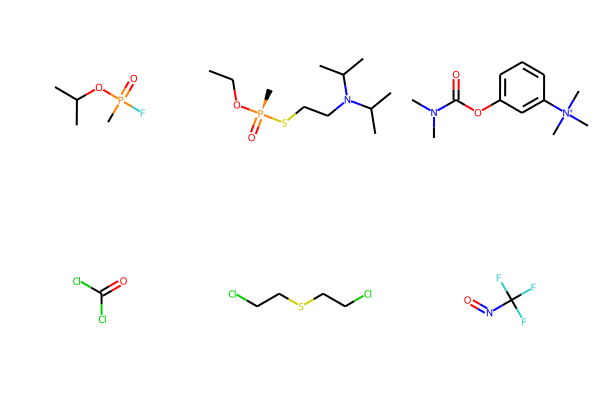

In [1087]:
toxins = range(0, 6)
toxin_SMILES_strings = known_toxins_df.iloc[toxins]['ids']
ms = [Chem.MolFromSmiles(x) for x in toxin_SMILES_strings] 
Draw.MolsToGridImage(ms)

In [1088]:
toxin_features = featurizer.featurize(known_toxins_df['ids'])
toxin_features

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1089]:
toxin_features = pd.DataFrame(toxin_features)

In [1090]:
toxin_features

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1091]:
known_toxins_df

,ids,Tox
0,FP(OC(C)C)(C)=O,1
1,O=[P@](OCC)(SCCN(C(C)C)C(C)C)C,1
2,CN(C)C(=O)OC1=CC=CC(=C1)[N+](C)(C)C,1
3,ClC(Cl)=O,1
4,ClCCSCCCl,1
5,FC(F)(F)N=O,1


In [1092]:
known_toxin_pred = clf.predict(toxin_features)

c:\Users\cu19339\AppData\Local\anaconda3\envs\ml-for-chemists-tf2\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [1093]:
known_toxin_pred

array([0, 0, 1, 0, 0, 0])

Model is predicting that all of the known toxins are non-toxic except for neostigmine. This is doesn't look great, adjusting hyperparameters may help:

In [1094]:
clf = RandomForestClassifier(criterion='gini',   # gini criteron measures the probability of misclassification for each split - values close to zero are ideal.
                             max_depth = 70,     # maximum depth of each decision tree
                             min_samples_split = 50,  # minimum number of samples required to split an internal node
                             random_state = 5)

In [1095]:
clf.fit(X_train, y_train)

c:\Users\cu19339\AppData\Local\anaconda3\envs\ml-for-chemists-tf2\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(max_depth=70, min_samples_split=50, random_state=5)

In [1096]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [1097]:
confusion_matrix(y_test, y_pred)

array([[493,  89],
       [ 93, 109]], dtype=int64)

In [1098]:
accuracy_score(y_test, y_pred)

0.7678571428571429

In [1099]:
fbeta_score(y_test, y_pred, beta=2)

0.5417495029821073

The accuracy of the model has improved slightly, but the main concern is the worse f2 score of 54%. This metric is the most important to maximize as we want to limit the number of false negatives as much as possible. For these hyperparameters, there are 93 false negatives - rendering this model too unreliable for real use. Lets see how this more general model performs on the known toxins:

In [1100]:
known_toxin_pred = clf.predict(toxin_features)
known_toxin_pred

c:\Users\cu19339\AppData\Local\anaconda3\envs\ml-for-chemists-tf2\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([0, 0, 0, 0, 0, 0])

Now it is predicting all to be non-toxic. However, this could be explained by the nature of the training data. As we have trained the model to look for toxins of *nuclear receptors* and the targets for each of these potent toxins are of a much different class (e.g., Sarin inhibits acetylcholinesterase, not a nuclear receptor), we shouldn't necessarily expect compounds of these classes to be accurately classified by our model.

We can conclude that this RF model is moderately successful at predicting the toxicity of compounds to the seven nuclear receptors assayed in this dataset, however, the model is useless when attempting to predict toxicity of compounds against significantly different targets. To confidently use this model as a method to predict toxicity against the seven nuclear receptors would be ill-advised since there still remains a significant number of false-positive results.